# Image matching with Siamese networks
## Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torch.utils.data import DataLoader
import utilities as utils 
from siameseDataloader import readDataFolder, dataSplits, MyImagenetDataset, EmbeddingDataset

import torch.nn as nn

from classifierModels import SimpleNetwork,Resnet20, EfficientNet,MobileNet,FCnet

In [2]:
import os
config = utils.load_config()
datadir = os.path.join('data','tiny-imagenet-200-copy','train')#config['DATASET']['root']
numclasses = config['DATASET']['numclasses']
im_size = config['DATASET']['im_size']
emb_size = config['MODEL']['embsize']

seed = config['seed']
np.random.seed(seed)

## Dataset for embs

In [3]:
if config['MODEL']['model']=='embeddings':
    train_dataset = EmbeddingDataset('trainembs.pkl')
    val_dataset = EmbeddingDataset('valembs.pkl')
    test_dataset = EmbeddingDataset('valembs.pkl')

## Dataset

In [ ]:
dataset = readDataFolder(datadir,numclasses)
print(dataset)


In [ ]:
train_split,val_split,test_split = dataSplits(dataset,0.8,0.2,0)

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(im_size+4),
    transforms.CenterCrop(im_size),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    transforms.Normalize([0.507, 0.4865, 0.4409], [0.2673, 0.2564, 0.2761])
])
test_transforms = transforms.Compose([
    transforms.Resize(im_size),
    transforms.CenterCrop(im_size),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    transforms.Normalize([0.507, 0.4865, 0.4409], [0.2673, 0.2564, 0.2761])
])

train_dataset = MyImagenetDataset(train_split,train_transforms)
val_dataset = MyImagenetDataset(val_split,test_transforms)
test_dataset = MyImagenetDataset(test_split,test_transforms)

datasets = {'train':train_dataset,'val':val_dataset,'test':test_dataset}

## Dataloader

In [5]:
#dataloaders
dataloaders = {
    'train': DataLoader(train_dataset,shuffle=True,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize']),
    'val': DataLoader(val_dataset,shuffle=False,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize']),
    'test': DataLoader(test_dataset,shuffle=False,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize'])
}

## Model

In [22]:
if config['MODEL']['model'] == 'simple':
    model = SimpleNetwork(numclasses=numclasses,pretrained=config['MODEL']['pretrained'])
elif config['MODEL']['model'] == 'resnet':
    model = Resnet20(numclasses=numclasses)
elif config['MODEL']['model'] == 'mobilenet':
    model = MobileNet(numclasses=numclasses)
elif config['MODEL']['model'] == 'efficient':
    model = EfficientNet(numclasses=numclasses)
elif config['MODEL']['model']=='embeddings':
    model = FCnet(emb_size*2,1)
else:
    model = SimpleNetwork()

In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

6849


In [ ]:
data,labels = train_dataset[100]
out = model(data.reshape(1,3,im_size,im_size))
print(out)

top_p , top_class = torch.topk(out,1,dim=1)
equals = top_class.view(size=labels.shape) == labels
print(labels,top_class,equals)


## Train

In [24]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

config['TRAIN']['lr'] =0.0005
optimizer = optim.Adam(model.parameters(),lr = config['TRAIN']['lr'],weight_decay=0)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [25]:
device = config['TRAIN']['device']
model = model.to(device)

In [26]:
loss_history ={'train':[],'val':[]}
acc_history ={'train':[],'val':[]}

In [27]:

for epoch in range(config['TRAIN']['numepochs']):
    for mode in ['train','val']:
        loss_epoch=0
        count=0
        correct=0
        
        for i,(img,label) in enumerate(dataloaders[mode]):
            img = img.to(device)
            label = label.to(device)
            
            if mode=='train':
                model.train()
                
                optimizer.zero_grad()
                out = model(img)
                loss = criterion(out,label)
                loss.backward()
                optimizer.step()
                
            else:
                model.eval()
                with torch.no_grad():
                    out = model(img)
                    loss = criterion(out,label)
            
            # track total loss
            loss_epoch = loss_epoch+loss
            count = count + len(label)
            
            #top_p , top_class = torch.topk(out,1,dim=1)
            #equals = label-top_class.flatten()==0
            top_class = (out>=0.5)*1.0
            equals = label.flatten()-top_class.flatten()==0
            
            correct += torch.sum(equals)
            
        scheduler.step()

        loss_history[mode].append(loss_epoch.item()/count)
        acc_history[mode].append(correct.item()*1.0/count)
    
    print('Epoch: {}\t train loss:{:.5},\t val loss:{:.5},\t train acc:{:.5},\t val acc:{:.5}'.format(epoch,loss_history['train'][-1],loss_history['val'][-1],acc_history['train'][-1],acc_history['val'][-1]))
    
            
            

Epoch: 0	 train loss:0.0083228,	 val loss:0.0083172,	 train acc:0.7591,	 val acc:0.7504
Epoch: 1	 train loss:0.0060072,	 val loss:0.0080767,	 train acc:0.82835,	 val acc:0.759
Epoch: 2	 train loss:0.0057448,	 val loss:0.0081343,	 train acc:0.8379,	 val acc:0.7618
Epoch: 3	 train loss:0.005615,	 val loss:0.0080133,	 train acc:0.842,	 val acc:0.7644
Epoch: 4	 train loss:0.0055911,	 val loss:0.0080294,	 train acc:0.8419,	 val acc:0.7648
Epoch: 5	 train loss:0.0055773,	 val loss:0.0080434,	 train acc:0.8421,	 val acc:0.7648
Epoch: 6	 train loss:0.0055695,	 val loss:0.0080475,	 train acc:0.84225,	 val acc:0.7648


KeyboardInterrupt: 

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(loss_history['train'],'b-')
ax[0].plot(loss_history['val'],'r-')
ax[0].set_title('Loss')
ax[1].plot(acc_history['train'],'b-')
ax[1].plot(acc_history['val'],'r-')
ax[1].set_title('Acc')

# SVM

In [38]:
X_train, y_train = torch.load('trainembs.pkl')
X_val,y_val = torch.load('valembs.pkl')

X_train = np.array(X_train)
y_train =np.array(y_train).ravel()
X_val = np.array(X_val)
y_val = np.array(y_val).ravel()


In [88]:
from sklearn import svm
clf = svm.SVC(C=0.5,probability=True)

In [109]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=0.1)

In [110]:
clf.fit(X_train, y_train)

MLPClassifier(alpha=0.1)

In [111]:
prediction_train = clf.predict(X_train)
prediction_val = clf.predict(X_val)

In [112]:
acc_train = np.sum(prediction_train == y_train)/len(y_train)
acc_val = np.sum(prediction_val == y_val)/len(y_val)
print(acc_train,acc_val)

0.8613 0.7802


In [113]:
out = clf.predict_proba(X_val)[:,1]

In [114]:
threshs= np.linspace(0,1,11)
accs = []
sensitivity = []
specificity = []
f1 = []
label = y_val
for thresh in threshs:
    conf = np.zeros((2,2))
    conf[1,1] = np.matmul(label.T,(out>=thresh)*1)
    conf[1,0] = np.matmul(label.T,(out<thresh)*1)
    conf[0,1] = np.matmul((1-label).T,(out>=thresh)*1)
    conf[0,0] = np.matmul((1-label).T,(out<thresh)*1)
    pos = np.sum(label)
    neg = np.sum(1-label)

    accs.append(((conf[1,1]+conf[0,0])/(pos+neg)))
    sensitivity.append((conf[0,0]/neg)) 
    specificity.append((conf[1,1]/pos))
    f1.append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])))
    

In [115]:
accs = np.array(accs)
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)
f1 = np.array(f1)

m1 = np.argmax(accs)
m2 = np.argmax(f1)

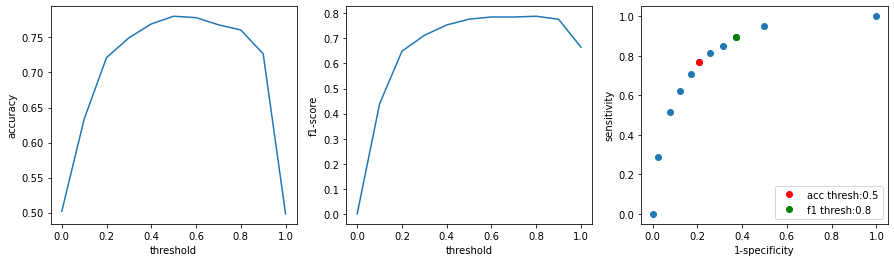

In [116]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(threshs,accs)
ax[0].set_xlabel('threshold')
ax[0].set_ylabel('accuracy')
ax[1].plot(threshs,f1)
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('f1-score')
ax[2].plot(1-specificity,sensitivity,'o',label='_nolabel_')
ax[2].set_xlabel('1-specificity')
ax[2].set_ylabel('sensitivity')
ax[2].plot(1-specificity[m1],sensitivity[m1],'ro',label='acc thresh:{}'.format(threshs[m1]))
ax[2].plot(1-specificity[m2],sensitivity[m2],'go',label='f1 thresh:{}'.format(threshs[m2]))
ax[2].legend()